In [2]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import deque
import random
import matplotlib.pyplot as plt
import time
import pandas as pd


In [3]:
class Qnet(nn.Module): #Set up a class that is a neural network non linear function approximation for a q learning agent
    def __init__(self,state_space, action_space):
        super(Qnet, self).__init__()
        self.seed = torch.manual_seed(12)
        self.L1 = nn.Linear(state_space, 32)  #Set up the Q network with two hidden layers of size 32. Lines 5-7 are the two hidden layer
        self.L23 = nn.Linear(32,32)
        self.L4 = nn.Linear(32,action_space)
        self.relu = torch.nn.ReLU()

#         self.L1 = nn.Linear(state_space, 32) #Lines 10-11 are the code for one hidden layer
#         self.L2 = nn.Linear(32,action_space)
    
        
    def forward(self,current_state): 
        output = self.L1(current_state)  #Line 15 - 18 are the code for two hidden layers
        output = self.relu(output)
        output = self.L23(output)
        output = self.relu(output)

#         output = self.L1(current_state) #Lines 20-21 are the code for one hidden layer
#         output = self.relu(output)


        return self.L4(output) #Change to self.L4(output) for two hidden layers, changes to self.L2(output) for one layer


In [4]:
class QLearningAgent():
    def __init__(self,state_space, action_space,replay_size,batch_num,gamma):
        self.state_space = state_space
        self.action_space = action_space
        self.replay_size = replay_size
        self.batch_num = batch_num
        self.gamma = gamma
        
        #initialize the replay buffer as a deque variable 
        self.replay_buffer = deque(maxlen = self.replay_size)
        
        self.Q_trainer = Qnet(8,4) #Initialize the Q neural net that will be the one that learns
        self.Q_target = Qnet(8,4) #Initialize the Q neural net that will be the one that is the target
        self.optimizer = torch.optim.Adam(self.Q_trainer.parameters(), lr=0.0001)
    
    def choose_action(self,state,epsilon): #Agent chooses the epsilon-greedy policy given the current state
        self.state = state #the current state is a numpy array. To feed into Qnet need to convert to torch.tensor
        test = np.random.random() #choose a random number between 0 and 1
        self.epsilon = epsilon
        if test>self.epsilon: #take the current QNet approximation and given current state, which of the four actions give the max value
            self.Q_trainer.eval() #set the Q_trainer network in evaluation mode
            
            self.state_torch = torch.from_numpy(self.state).float().unsqueeze(0) #convert the current state into a tensor to input into Qnet
            
            with torch.no_grad():
                actions_ = self.Q_trainer(self.state_torch)
            self.Q_trainer.train()
            self.action = np.argmax(actions_.data.numpy())
    
        if test<=self.epsilon:
            self.action = random.randint(0,3)
        
        return self.action #return the action that is from the epsilon-greedy policy

    def QLearn(self,state,action,next_state,reward,term,learning_count): #take a step and learn from it using experience replay. Add it the experience to the memory buffer
        
        self.next_state = next_state
        #self.state is already defined in the choose_action method 
        #self.action is already defined in the choose_action method
        self.reward = reward
        self.term = term
        self.learning_count = learning_count
        
        new_experience = self.state,self.action,self.reward,self.next_state,self.term
        #Add this new experience to the 
        self.replay_buffer.append(new_experience)
    
        #check that the length of the replay buffer is enough from what we have defined a batch size is
        if len(self.replay_buffer)>self.batch_num:
            learning = 1
        else:
            learning = 0
        
        if learning == 1: #If we have enough batches to complete learning, do some learnin
            #Grab the batch_num random number of samples from replay buffer
            experiences_sample = random.sample(list(self.replay_buffer),self.batch_num)
            
            #Need to get the next states into a torch.tensor and into Q_target
            self.states = [x[0] for x in experiences_sample]
            self.actions = [y[1] for y in experiences_sample]
            self.rewards = [w[2] for w in experiences_sample]
            self.next_states = [z[3] for z in experiences_sample]
            self.terms = [g[4] for g in experiences_sample]
            
            #Change all the batch sample data into tensor
            
            self.states_torch = torch.tensor(np.array(self.states)).float()
            self.actions_torch = torch.tensor(np.array(self.actions)).type(torch.int64)
            self.rewards_torch = torch.tensor(np.array(self.rewards)).float()
            self.next_states_torch = torch.tensor(np.array(self.next_states)).float()
            self.terms_torch = torch.tensor(np.array(self.terms)).float()
            
            #Use the Q_target and next states to estimate the max value function of the next states
            target = self.Q_target(self.next_states_torch).detach().max(1)[0].unsqueeze(1)

            #Use Q learning algorith to define the target
            q_target = self.rewards_torch.unsqueeze(1) + self.gamma * target * (1 - self.terms_torch.unsqueeze(1))
            
            
            #Training Q approximation
            training_output = self.Q_trainer(self.states_torch).gather(1,self.actions_torch.unsqueeze(1))
#             print(training_output.shape,self.actions_torch.shape).gather(1,self.actions_torch.unsqueeze(1))
#             .gather(1,self.actions_torch)

        
            #Use MSE as the loss function
#             print(q_target.shape,training_output.shape)
            loss = F.mse_loss(training_output,q_target)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            self.learning_count += 1
        
            #After a thousand learning steps, copy over the 
            if self.learning_count%1000 == 0:
                
                for target_par, training_par in zip(self.Q_target.parameters(), self.Q_trainer.parameters()):target_par.data.copy_(training_par.data)
        
        
        
        
        return 
        
        
        
    
    
    

In [5]:
def DQNLearning(n_episodes):
    begin = time.time()
    Batch_size = 64
    learning_count = 0
    score = []
    epsilon = 1 #starting value for epsilon
    for episode in range(n_episodes):
        env = gym.make('LunarLander-v2') #Initialize the Lunar Lander environment
        state = env.reset() #numpy array of the current 
        number_inputs = 8
        number_outputs = 4
        scores = 0
        for i in range(1000):
            #call the agent to choose the epsilon greedy action
            
            action = agent.choose_action(state,epsilon)
            
            #agent takes the step and observe what the next state, reward, and whether entered a terminal state
            next_state,reward,term,_ = env.step(action)
            
            #agent takes the state, action, reward, next state and saves it to memory. And then learns/updates Qnet
            agent.QLearn(state=state, action=action, next_state=next_state, reward=reward,term=term,learning_count=learning_count)
            learning_count = agent.learning_count
            #update the state to the next state
            state = next_state
            scores+=reward
            
            if term == 1:
                break
        print(episode)
        
        #decay epsilon to do less exploration the more we have trained
#         epsilon = max(0.1, 0.995*epsilon) #turn off for no epsilon decay capability
        
        score.append(scores)
    duration = (time.time()-begin)/60
    return score,duration

        
        

In [53]:
agent = QLearningAgent(state_space=8, action_space=4,replay_size=100000,batch_num=64,gamma=0.99)
score_hist,duration = DQNLearning(1000)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

-125.36724823406479 56.4765097755696


Text(0.5, 1.0, 'DQN Sixth Hyperparameters Trained Agent')

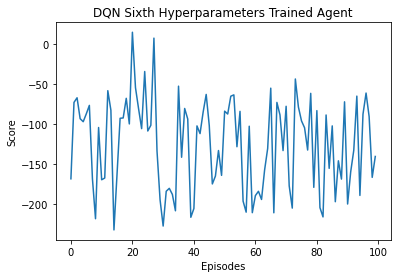

In [56]:
# #Code to test my trained agent with 100 episdoes to see how well it scores
scores_test = np.zeros(100)
steps = np.zeros(100)
for j in range(100):
        env = gym.make('LunarLander-v2') #Initialize the Lunar Lander environment
        state = env.reset()
    
        for k in range(1000):
            agent.Q_trainer.eval() #set the Q_trainer network in evaluation mode

            state_torch = torch.from_numpy(state).float().unsqueeze(0) #convert the current state into a tensor to input into Qnet

            with torch.no_grad():
                actions_ = agent.Q_trainer(state_torch)
            agent.Q_trainer.train()
            
            #Choose the action that has the highest estimated value from the trained DQN agent
            action = np.argmax(actions_.data.numpy())
            next_state,reward,term,_ = env.step(action)
            
            scores_test[j]+=reward
            state = next_state
            steps[j]+=1
            
            if term == 1:
                break
            

print(scores_test.mean(),np.std(scores_test))
plt.plot(scores_test)
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.title('DQN Sixth Hyperparameters Trained Agent')

Text(0.5, 1.0, 'DQN Sixth Hyperparameters Trained Agent')

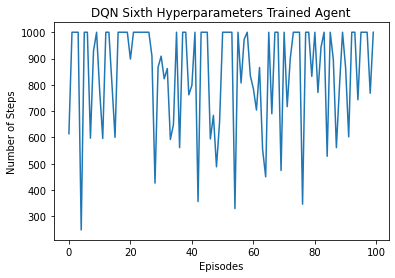

In [58]:
plt.plot(steps)
plt.xlabel('Episodes')
plt.ylabel('Number of Steps')
plt.title('DQN Sixth Hyperparameters Trained Agent')


Text(0.5, 1.0, 'DQN Sixth Hyperparameters Training')

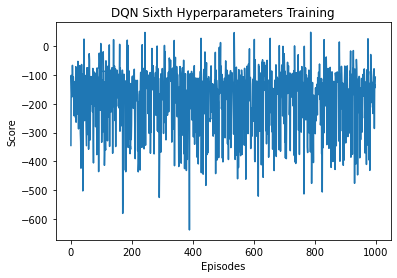

In [95]:
# show_video_of_model(agent, 'LunarLander-v2')
plt.plot(score_hist)
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.title('DQN Sixth Hyperparameters Training')

In [111]:
# pd.DataFrame(score_hist).to_csv('H6 Training.csv')
# pd.DataFrame(scores_test).to_csv('H6 Test.csv')
# pd.DataFrame(steps).to_csv('H6 steps.csv')

In [115]:
# H1_training = pd.read_csv('H1 Training.csv')
# H2_training = pd.read_csv('H2 Training.csv')
# H3_training = pd.read_csv('H3 Training.csv')
# H4_training = pd.read_csv('H4 Training.csv')
# H5_training = pd.read_csv('H5 Training.csv')
# H6_training = pd.read_csv('H6 Training.csv')

# H2_score = pd.read_csv('H2 Test.csv')
# H3_score = pd.read_csv('H3 Test.csv')
# H4_score = pd.read_csv('H4 Test.csv')
# H5_score = pd.read_csv('H5 Test.csv')
# H6_score = pd.read_csv('H6 Test.csv')

# H2_steps = pd.read_csv('H2 steps.csv')
# H3_steps = pd.read_csv('H3 steps.csv')
# H4_steps = pd.read_csv('H4 steps.csv')
# H5_steps = pd.read_csv('H5 steps.csv')
# H6_steps = pd.read_csv('H6 steps.csv')


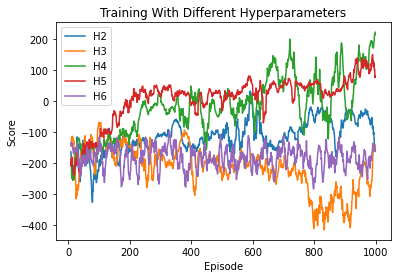

In [118]:
# # plt.plot(H1_training.iloc[:,1].rolling(10).mean(),label="H1")
# plt.plot(H2_training.iloc[:,1].rolling(10).mean(),label="H2")
# plt.plot(H3_training.iloc[:,1].rolling(10).mean(),label="H3")
# plt.plot(H4_training.iloc[:,1].rolling(10).mean(),label="H4")
# plt.plot(H5_training.iloc[:,1].rolling(10).mean(),label="H5")
# plt.plot(H6_training.iloc[:,1].rolling(10).mean(),label="H6")
# plt.title('Training With Different Hyperparameters')
# plt.xlabel('Episode')
# plt.ylabel('Score')
# plt.legend(loc="upper left")

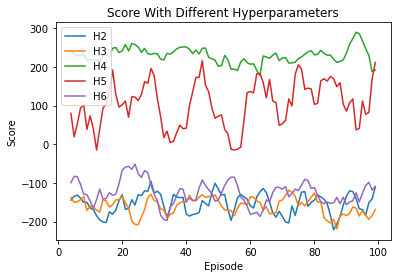

In [120]:

# plt.plot(H2_score.iloc[:,1].rolling(5).mean(),label="H2")
# plt.plot(H3_score.iloc[:,1].rolling(5).mean(),label="H3")
# plt.plot(H4_score.iloc[:,1].rolling(5).mean(),label="H4")
# plt.plot(H5_score.iloc[:,1].rolling(5).mean(),label="H5")
# plt.plot(H6_score.iloc[:,1].rolling(5).mean(),label="H6")
# plt.title('Score With Different Hyperparameters')
# plt.xlabel('Episode')
# plt.ylabel('Score')
# plt.legend(loc="upper left")